In [ ]:
%pip install --quiet -U langgraph langchain_groq langgraph_sdk langgraph-prebuilt

In [ ]:
import os
import sqlite3
from google.colab import userdata

api_key = userdata.get("groq_api_key")
os.environ["GROQ_API_KEY"] = api_key
os.environ["LANGCHAIN_TRACKING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="langchain-academy"

In [ ]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    temperature=0.7,
    model_name="llama3-8b-8192",
    verbose=True
)

In [ ]:
def multiply(a:int,b:int)->int:
  """multiply a and b"""
  return a*b

def add(a:int,b:int)->int:
  """add a and b"""
  return a+b

def divide(a:int,b:int)->int:
  """divide a and b"""
  return a/b

tools=[multiply,divide,add]
llm_with_tools=llm.bind_tools(tools)

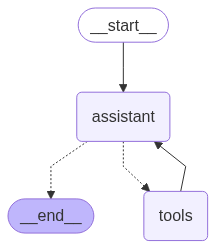

In [ ]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = {"configurable": {"thread_id": "1"}}
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (dtg6dhsae)
 Call ID: dtg6dhsae
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

6


In [ ]:
graph.get_state({"configurable":{"thread_id":"1"}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='e3669d5b-2548-42d6-b160-462bd5a910d1'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'dtg6dhsae', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 1097, 'total_tokens': 1170, 'completion_time': 0.067901188, 'prompt_time': 0.122769534, 'queue_time': 0.056620802, 'total_time': 0.190670722}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_5b339000ab', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d80b0f22-f710-428d-abc6-213729953558-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'dtg6dhsae', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1097, 'output_tokens': 73, 'total_tokens': 1170}), ToolMessage(content='6', name='multiply', id='bc9a1b16-b511-4ef2-a5c9

In [ ]:
all_states=[s for s in graph.get_state_history(thread)]

In [ ]:
len(all_states)

5

In [ ]:
all_states[4]

StateSnapshot(values={'messages': []}, next=('__start__',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0798cd-922d-6299-bfff-1900c9537b23'}}, metadata={'source': 'input', 'step': -1, 'parents': {}}, created_at='2025-08-15T04:03:49.380557+00:00', parent_config=None, tasks=(PregelTask(id='7e65e89e-ab85-4111-f578-ff90b0e3f8a8', name='__start__', path=('__pregel_pull', '__start__'), error=None, interrupts=(), state=None, result={'messages': HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='e3669d5b-2548-42d6-b160-462bd5a910d1')}),), interrupts=())

In [ ]:
import pprint

for i, state in enumerate(all_states, start=1):
    print(f"\n--- State #{i} ---")
    pprint.pprint(state)


--- State #1 ---
StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='e3669d5b-2548-42d6-b160-462bd5a910d1'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'dtg6dhsae', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 1097, 'total_tokens': 1170, 'completion_time': 0.067901188, 'prompt_time': 0.122769534, 'queue_time': 0.056620802, 'total_time': 0.190670722}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_5b339000ab', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d80b0f22-f710-428d-abc6-213729953558-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'dtg6dhsae', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1097, 'output_tokens': 73, 'total_tokens': 1170}), ToolMessage(content='6', name='multiply', id='bc9a1

In [ ]:
def print_chat_replay(all_states):
    for i, state in enumerate(reversed(all_states), start=1):  # reverse to start from earliest
        messages = state.values.get("messages", [])
        for msg in messages:
            # Detect type of message
            role = type(msg).__name__.replace("Message", "")
            if hasattr(msg, "name") and msg.name:  # ToolMessage case
                role = f"Tool:{msg.name}"
            print(f"{role}: {msg.content}")
        print("-" * 40)

In [ ]:
print_chat_replay(all_states)

----------------------------------------
Human: Multiply 2 and 3
----------------------------------------
Human: Multiply 2 and 3
AI: 
----------------------------------------
Human: Multiply 2 and 3
AI: 
Tool:multiply: 6
----------------------------------------
Human: Multiply 2 and 3
AI: 
Tool:multiply: 6
AI: 6
----------------------------------------


In [ ]:
to_replay=all_states[-2]

In [ ]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='e3669d5b-2548-42d6-b160-462bd5a910d1')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0798cd-922f-61e9-8000-324a6b8d1863'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-08-15T04:03:49.381358+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0798cd-922d-6299-bfff-1900c9537b23'}}, tasks=(PregelTask(id='90f5c29a-bc06-4dc9-b2f0-59c64840f4b7', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'dtg6dhsae', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 1097, 'total_tokens': 1170, 'completion_ti

In [ ]:
to_replay.next

('assistant',)

In [ ]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0798cd-922f-61e9-8000-324a6b8d1863'}}

In [ ]:
for event in graph.stream({"messages": [HumanMessage(content="Multiply 2 and 3")]},to_replay.config,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (eeh2sdv7r)
 Call ID: eeh2sdv7r
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

6


In [ ]:
to_fork=all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='e3669d5b-2548-42d6-b160-462bd5a910d1')]

In [ ]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0798cd-922f-61e9-8000-324a6b8d1863'}}

In [ ]:
fork_config=graph.update_state(
    to_fork.config,
    {"messages":[HumanMessage(content="Mutiply 3 and 5",
                              id=to_fork.values["messages"][0].id
    )]}
)

In [ ]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0798cd-a8df-6c0b-8001-849468da500f'}}

In [ ]:
all_states=[s for s in graph.get_state_history(thread)]
len(all_states)

11

In [ ]:
all_states[0]

StateSnapshot(values={'messages': [HumanMessage(content='Mutiply 3 and 5', additional_kwargs={}, response_metadata={}, id='e3669d5b-2548-42d6-b160-462bd5a910d1')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0798cd-a8df-6c0b-8001-849468da500f'}}, metadata={'source': 'update', 'step': 1, 'parents': {}}, created_at='2025-08-15T04:03:51.760568+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0798cd-922f-61e9-8000-324a6b8d1863'}}, tasks=(PregelTask(id='e7815330-6270-79f9-437b-69c309852bcb', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [ ]:
for event in graph.stream(None,fork_config,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Mutiply 3 and 5
================================== Ai Message ==================================
Tool Calls:
  multiply (fxqvgzf9w)
 Call ID: fxqvgzf9w
  Args:
    a: 3
    b: 5
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================
Tool Calls:
  multiply (vm8fs14b2)
 Call ID: vm8fs14b2
  Args:
    a: 15
    b: 5
================================= Tool Message =================================
Name: multiply

75
================================== Ai Message ==================================

The answer is 75.
